In [1]:
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.special import gamma
from time import time
import igraph as ig
import numpy as np
# import powerlaw
import random
import heapq

In [2]:
n = 10000
m = int(2*n)

def GNM(n, m):
    forbiddenEdges = defaultdict(set)
    rangeSet = set(range(n))    
    edges = []
    for _ in range(m):
        i = random.randrange(n)
        j = random.choice(tuple(
            rangeSet.difference(forbiddenEdges[i].union({i}))
        ))
        forbiddenEdges[i].add(j)
        forbiddenEdges[j].add(i)
        edges.append((i,j))    
    g = ig.Graph(n) 
    g.add_edges(edges)
    return g

start = time()
g = GNM(n, m)
print(f"n:{n}, m: {m}, time: {round(time()-start, 4)} s")
#g.save(f"GNM/GNMn{n}m{m}.net")
#ig.plot(g, f"GNM/GNMn{n}m{m}.png")

for n in (50, 100, 1000):
    for i in range(1, 6):        
        #GNM(n, n*i).save(f"GNM/GNMn{n}m{n*i}.net")
        pass

n:10000, m: 20000, time: 10.7456 s


In [3]:
n = 10000
p = 0.1

def GNP(n, p):       
    possibleEdges = combinations(range(n), 2)
    r = random.random    
    g = ig.Graph(n)
    g.add_edges(edge for edge in possibleEdges if r() < p)
    return g

start = time()
g = GNP(n, p)
print(f"n:{n}, p: {p}, time: {round(time()-start, 4)} s")
# g.save(f"GNP/GNPn{n}p{str(p).replace('.', '_')}.net")
# ig.plot(g, f"GNP/GNPn{n}p{str(p).replace('.', '_')}.png")

for n in (50, 100, 1000):
    for p in (0.0, 0.1, 0.2, 0.5, 0.9, 1.0):        
        # GNP(n, p).save(f"GNP/GNPn{n}p{str(p).replace('.', '_')}.net")
        pass

n:10000, p: 0.1, time: 21.2432 s


In [4]:
n = 10000
p = 0.75

def WS(n, p):
    g = ig.Graph(n)
    sources = list(range(n))
    forbiddenEdges = {i: {i} for i in sources}
    for i in (1, 2):
        targets = sources[i:] + sources[0:i]
        g.add_edges(list(zip(sources, targets)))
        for source, target in zip(sources, targets):
            forbiddenEdges[source].add(target)
            forbiddenEdges[target].add(source)
    sources = set(sources)
    toDelete = []
    toAdd = []
    for i, old_j in g.get_edgelist():
        if random.random() < p:
            forbiddenEdges[i].remove(old_j)
            forbiddenEdges[old_j].remove(i)
            toDelete.append((i, old_j))
            
            new_j = random.choice(tuple(
                sources.difference(forbiddenEdges[i])
            ))
            forbiddenEdges[i].add(new_j)
            forbiddenEdges[new_j].add(i)
            toAdd.append((i, new_j))            

    g.delete_edges(toDelete)
    g.add_edges(toAdd)
    return g

start = time()
g = WS(n, p)
print(f"n:{n}, p: {p}, time: {round(time()-start, 4)} s")
# g.save(f"WS/WSn{n}p{str(p).replace('.', '_')}.net")
# ig.plot(g, f"WS/WSn{n}p{str(p).replace('.', '_')}.png")

for n in (50, 100, 1000):
    for p in (0.0, 0.1, 0.2, 0.5, 0.9, 1.0):        
        # WS(n, p).save(f"WS/WSn{n}p{str(p).replace('.', '_')}.net")
        pass

n:10000, p: 0.75, time: 9.2005 s


In [16]:
n = 10000
m0 = 5
m = 5

def BA(n, m, m0):
    vertices = list(range(m0))
    forbiddenEdges = set()
    degrees = [m0-1] * m0    
    edges = []    
    for index in range(m0, n):
        forbiddenEdges.clear()      
        count = 0
        while count < m:
            target = random.choices(vertices, degrees)[0]
            if target not in forbiddenEdges:
                edges.append((index, target))
                forbiddenEdges.add(target)
                degrees[target] += 1                
                count += 1
        vertices.append(index)
        degrees.append(m)
    
    g = ig.Graph.Full(n=m0)
    g.add_vertices(n-m0)m
    g.add_edges(edges)
    return g

start = time()
g = BA(n, m, m0)
print(f"n:{n}, m: {m}, m0: {m0}, time: {round(time()-start, 4)} s")
# g.save(f"BA/BAn{n}m{m}M{m0}.net")
# ig.plot(g, f"BA/BAn{n}m{m}M{m0}.png")

m0 = 5
for n in (50, 100, 1000):
    for m in (1, 2, 5):
        # BA(n, m, m0).save(f"BA/BAn{n}m{m}M{m0}.net")
        pass

n:10000, m: 5, m0: 5, time: 33.0029 s


In [102]:
n = 10000
distributions = {
    "gamma": lambda n: np.random.gamma(5, 1, size=n).astype(int),
    "poisson": lambda n: np.random.poisson(5, n)
}

def CM(n, distribution):    
    forbiddenEdges = defaultdict(set)
    g = ig.Graph(n)
    edges = []
    
    degrees = [1]
    while sum(degrees) % 2 != 0:
        degrees = distribution(n)    
    stubs = {i: degree for i, degree in enumerate(degrees) if degree>0}
    heap = [(-degree, i) for i, degree in stubs.items()]    
    rangeSet = set(stubs.keys()) 
    heapq.heapify(heap)    
    
    while stubs:     
        source = None
        while source not in stubs:
            v, source = heapq.heappop(heap)
        targets = rangeSet.difference(forbiddenEdges[source].union({source}))
        target = random.choice(tuple(targets))        
        
        forbiddenEdges[source].add(target)
        forbiddenEdges[target].add(source)
        edges.append((source, target))

        for idx in (source, target):
            stubs[idx] -= 1
            if stubs[idx] == 0:
                rangeSet.remove(idx)
                del stubs[idx]
        
        if source in stubs:
            heapq.heappush(heap, (-stubs[source], source))
        
    g.add_edges(edges)
    return g

start = time()
g = CM(n, distributions["gamma"])
print(f"n:{n}, time: {round(time()-start, 4)} s")
# g.save(f"CM/CMn{n}gamma.net")
# ig.plot(g, f"CM/CMn{n}{name}.png")
for n in (50, 100, 1000):
    for name, distribution in distributions.items():
        # CM(n, distribution).save(f"CM/CMn{n}{name}.net")
        pass

n:10000, time: 19.2039 s


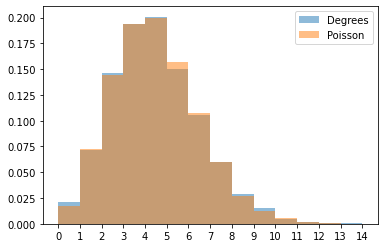

In [158]:
g = ig.load("GNM/GNMn10000m20000.net")
degrees = g.degree()
degreesMax = max(degrees)
degreesSize = len(degrees)
degreesMean = sum(degrees)/degreesSize

poisson = np.random.poisson(degreesMean, size=degreesSize)
poissonMax = max(poisson)

plt.hist(degrees, density=True, alpha=0.5, label="Degrees", bins=degreesMax)
plt.hist(poisson, density=True, alpha=0.5, label="Poisson", bins=poissonMax)
plt.xticks(range(degreesMax+1))
plt.legend()
plt.show()

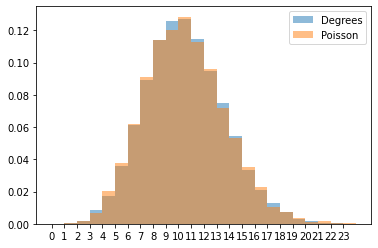

In [159]:
g = ig.load("GNP/GNPn10000p0_001.net")
degrees = g.degree()
degreesMax = max(degrees)
degreesSize = len(degrees)
degreesMean = sum(degrees)/degreesSize

poisson = np.random.poisson(degreesMean, size=degreesSize)
poissonMax = max(poisson)

plt.hist(degrees, density=True, alpha=0.5, label="Degrees", bins=degreesMax)
plt.hist(poisson, density=True, alpha=0.5, label="Poisson", bins=poissonMax)
plt.xticks(range(degreesMax+1))
plt.legend()
plt.show()

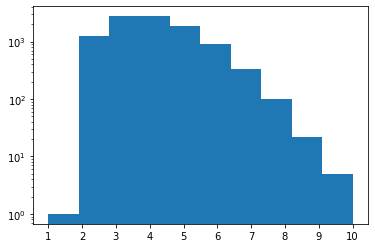

In [4]:
g = ig.load("WS/WSn10000p0_75.net")
x = g.degree()
maxX = max(x)

fig, ax = plt.subplots()
plt.xticks(range(maxX+1))
ax.hist(x, bins=maxX)
ax.set_yscale('log')
plt.show()

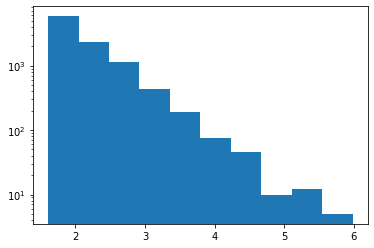

In [5]:
g = ig.load("BA/BAn10000m5M5.net")
x = np.log(g.degree())

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.hist(x)
plt.show()

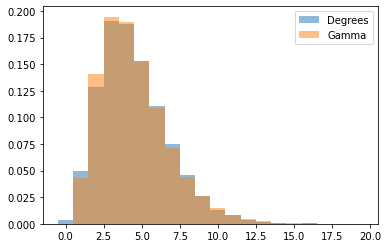

In [193]:
g = ig.load("CM/CMn10000gamma.net")
degrees = g.degree()
degreesMax = max(degrees)
degreesSize = len(degrees)
degreesStd = np.std(degrees)
degreesMean = sum(degrees)/degreesSize

shape = (degreesMean/degreesStd)**2
scale = (degreesStd**2)/degreesMean

heights, x = np.histogram(degrees, degreesMax, density=True)
binWidth = x[1] - x[0]
plt.bar(x[:-1], heights*binWidth, binWidth, alpha=0.5, label='Degrees')

y = x**(shape-1)*(np.exp(-x/scale)/(gamma(shape)*scale**shape))
plt.bar(x, y, binWidth, alpha=0.5, label="Gamma")

plt.legend()
plt.show()

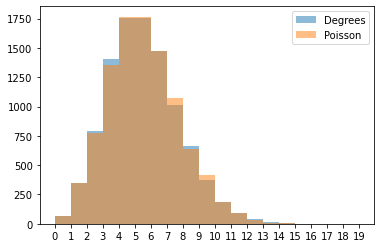

In [191]:
g = ig.load("CM/CMn10000poisson.net")
degrees = g.degree()
degreesMax = max(degrees)
degreesSize = len(degrees)
degreesMean = sum(degrees)/degreesSize

poisson = np.random.poisson(xMean, size=xSize)
poissonMax = max(poisson)

plt.hist(degrees, alpha=0.5, label="Degrees", bins=degreesMax)
plt.hist(poisson, alpha=0.5, label="Poisson", bins=poissonMax)
plt.xticks(range(maxX+1))
plt.legend()
plt.show()

Calculating best minimal value for power law fit
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Should be: 3 0
Is: 2.9864301116017247 0.07439239231299492


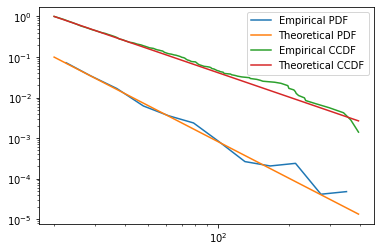

In [10]:
g = ig.load("BA/BAn10000m5M5.net")
data = g.degree()

fit = powerlaw.Fit(data)
print("Should be: 3 0")
print("Is:", fit.power_law.alpha, fit.power_law.sigma)

figCCDF = fit.plot_pdf(label="Empirical PDF")
fit.power_law.plot_pdf(ax=figCCDF, label="Theoretical PDF")

fit.plot_ccdf(ax=figCCDF, label="Empirical CCDF")
fit.power_law.plot_ccdf(ax=figCCDF, label="Theoretical CCDF")

plt.legend()
plt.show()

In [11]:
import math
g = ig.load("BA/BAn10000m5M5.net")
ks = g.degree()
denominator = min(ks) - 1/2
y = 1 + n/sum(math.log(k/denominator) for k in ks)
print(y)

1.174613458745331


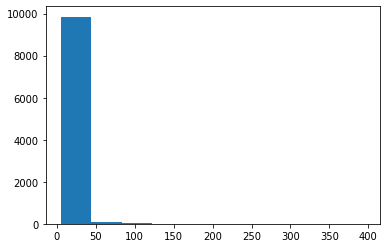

5 396 10000


In [204]:
g = ig.load("BA/BAn10000m5M5.net")
x = g.degree()

minX = min(x)
maxX = max(x)
xSize = len(x)

fig, ax = plt.subplots()
ax.hist(x)
plt.show()
print(minX, maxX, xSize)

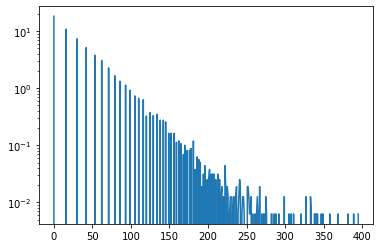

In [23]:
g = ig.load("BA/BAn10000m5M5.net")
x = g.degree()

minX = min(x)
maxX = max(x)
xSize = len(x)
uniqueX = len(set(x))

fig, ax = plt.subplots()
#ax.hist(x, bins=uniqueX, density=True)

results = np.histogram(np.log2(x), density=True, bins=maxX)[0]
#binWidth = edges[1] - edges[0]
#ax.bar(edges[:-1], results*binWidth, binWidth*20, align='edge')
ax.plot(results)

#ax.bar(range(len(results)), results)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show()
#print(minX, maxX, xSize, uniqueX)

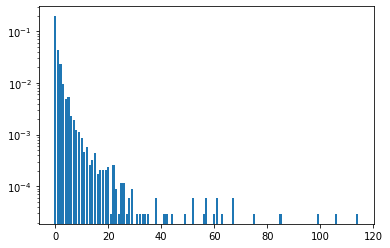

In [25]:
g = ig.load("BA/BAn10000m5M5.net")
x = g.degree()

minX = min(x)
maxX = max(x)
xSize = len(x)
uniqueX = len(set(x))

fig, ax = plt.subplots()
#ax.hist(x, bins=uniqueX, density=True)

results = np.histogram(x, density=True, bins=uniqueX)[0]
ax.bar(range(len(results)), results)
ax.set_yscale('log')
plt.show()
#print(minX, maxX, xSize, uniqueX)

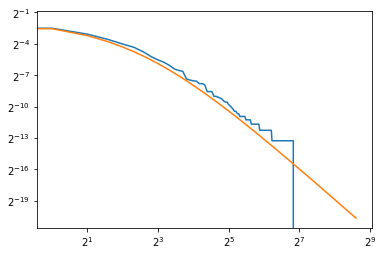

In [270]:
fig, ax = plt.subplots()

h = np.histogram(x, bins=maxX, density=True)[0]
ax.plot(sorted(h)[::-1])

#x2 = (minX**3)*np.arange(minX, maxX, dtype=float)**(-3)
x2 = np.arange(minX, maxX, dtype=float)**(-3)
x2 /= x2[0]/h[0]
ax.plot(x2)

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
plt.show()

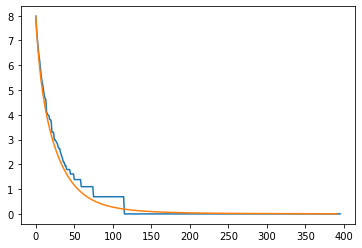

In [25]:
plt.plot(sorted(np.log1p(h))[::-1])
plt.plot(np.log1p(sorted(x2)[::-1]))

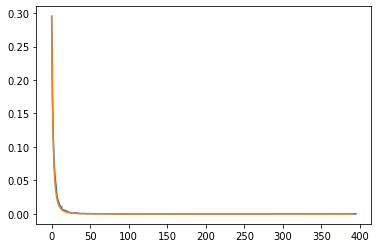

In [195]:
h = np.histogram(x, bins=maxX, density=True)[0]
plt.plot(h)

x2 = (h[0] * minX**3)*np.arange(minX, maxX, dtype=float)**(-3)
plt.plot(sorted(x2)[::-1])

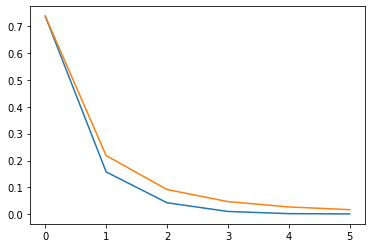

In [196]:
def log2int(n):
    return int(np.log2(n))

fig, ax = plt.subplots()
minX2, maxX2 = log2int(minX), log2int(maxX)

results = np.histogram(np.log2(x), density=True, bins=int(maxX2-minX2))[0]
ax.plot(results)

x2 = (results[0] * minX2**3)*np.arange(minX2, maxX2, dtype=float)**(-3)
ax.plot(sorted(x2)[::-1])

#ax.set_yscale('log', base=2)
plt.show()

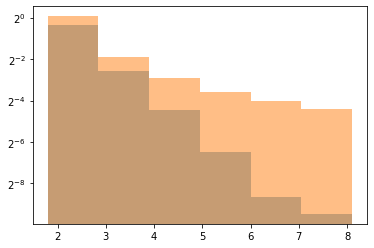

In [211]:
def log2int(n):
    return int(np.log2(n))

fig, ax = plt.subplots()
minX2, maxX2 = log2int(minX), log2int(maxX)

heights, xticks = np.histogram(np.log2(x), density=True, bins=int(maxX2-minX2))
binWidth = xticks[1] - xticks[0]
plt.bar(xticks[:-1], heights*binWidth, binWidth, alpha=0.5, label='Degrees')

x2 = (np.log2(minX2)**3)* np.log2(np.arange(minX2, maxX2, dtype=float)) **(-3)
#ax.plot(sorted(x2)[::-1])
plt.bar(xticks[:-1], x2*binWidth, binWidth, alpha=0.5, label='Powerlaw')

ax.set_yscale('log', base=2)
plt.show()

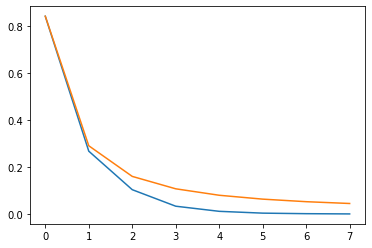

In [241]:
h = np.histogram(np.log2(x), bins=int(np.log2(maxX)), density=True)[0]
plt.plot(h)

x2 = (np.log2(minX)**3)*(np.log2(np.arange(np.log2(minX), np.log2(maxX)+1, dtype=float)))**(-3)
x2 *= h[0] / x2[0]
plt.plot(x2)